# Регрессия и прогнозирование ARIMA в statsmodels

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA

In [2]:
timeseries = pd.read_csv('crude-oil-exports-by-type-monthly.csv', header=0,delimiter=',')
timeseries = timeseries.loc[timeseries['Oil Type']=='Total'].filter(['Period','Volume (bbl/d)'])
timeseries['Period'] = timeseries['Period'].transform(lambda x: datetime.strptime(x, '%m/%d/%Y'))
timeseries.set_index(keys='Period',drop=True, inplace=True)
timeseries = timeseries.squeeze(axis=1)
timeseries

Period
1985-06-01    4.074025e+05
1985-07-01    3.680593e+05
1985-08-01    3.925685e+05
1985-09-01    5.325918e+05
1985-10-01    4.984505e+05
                  ...     
2020-11-01    3.774103e+06
2020-12-01    3.789375e+06
2021-01-01    3.883311e+06
2021-02-01    3.719741e+06
2021-03-01    3.658940e+06
Name: Volume (bbl/d), Length: 430, dtype: float64

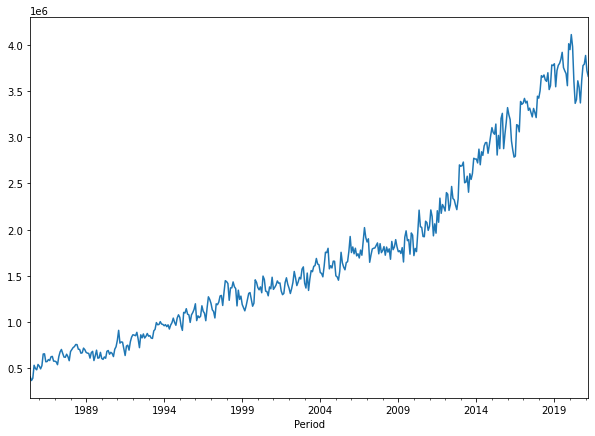

In [3]:
timeseries.plot(figsize=(10, 7))

## Подбор параметров регрессии

In [4]:
import warnings
warnings.filterwarnings("ignore")

p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(timeseries, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(9, 2, 1) 11081.114756643623


In [5]:
model = ARIMA(timeseries, order=best_pdq)
result = model.fit()

## Проверка оптимальности

In [6]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Volume (bbl/d)   No. Observations:                  430
Model:                 ARIMA(9, 2, 1)   Log Likelihood               -5529.557
Date:                Mon, 07 Jun 2021   AIC                          11081.115
Time:                        06:48:26   BIC                          11125.765
Sample:                    06-01-1985   HQIC                         11098.749
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3367      0.052     -6.490      0.000      -0.438      -0.235
ar.L2         -0.2644      0.056     -4.739      0.000      -0.374      -0.155
ar.L3         -0.2727      0.060     -4.566      0.000      -0.390      -0.156
ar.L4         -0.3604      0.053     -6.838      0.000      -0.464      -0.257
ar.L5         -0.1978      0.055     -3.612      0.000      -0.305      -0.090
ar.L6         -0.1349      0.064     -2.112      0.035      -0.260      -0.010
ar.L7         -0.1137      0.059     -1.917      0.055      -0.230       0.003
ar.L8         -0.1774      0.058     -3.083      0.002      -0.290      -0.065
ar.L9         -0.0972      0.055     -1.764      0.078      -0.205       0.011
ma.L1         -0.9902      0.009   -116.103      0.000      -1.007      -0.973
sigma2      1.166e+10   1.59e-12   7.32e+21      0.000    1.17e+10    1.17e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                38.97
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               4.96   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.19e+37. Standard errors may be unstable.
"""

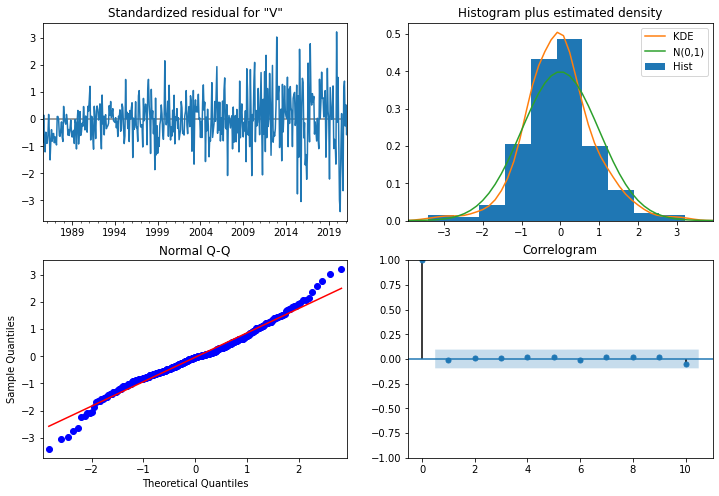

In [7]:
result.plot_diagnostics(figsize=(12, 8))
plt.show()

## Прогнозирование и оценка точности прогноза

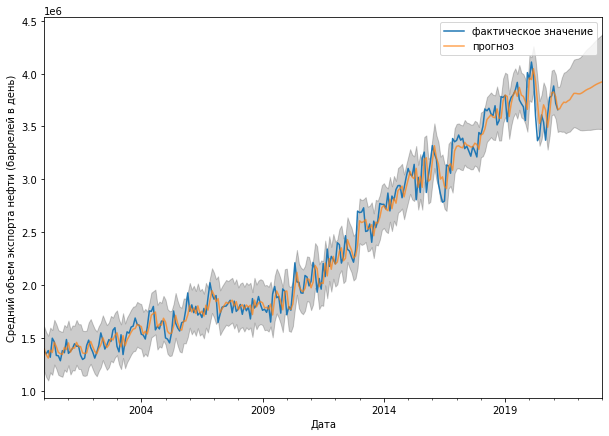

In [8]:
pred = result.get_prediction(start='2000-01-01', end='2023-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = timeseries['2000':].plot(label='фактическое значение', figsize=(10, 7))
pred.predicted_mean.plot(ax=ax, label='прогноз', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата')
ax.set_ylabel('Средний объем экспорта нефти (баррелей в день)')
plt.legend()
plt.show()

In [9]:
forecasted = pred.predicted_mean[:'2021-03-01']
actual = timeseries['2000':]
mape = np.mean(np.abs((actual - forecasted)/actual))*100
mape

3.803169962538107